In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 下載檔案

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_2021/hw1/covid.train.csv', index_col='id')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_2021/hw1/covid.test.csv', index_col='id')
# sample_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_2021/hw1/sampleSubmission.csv', index_col='id')

In [4]:
train_df.head()

,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [7]:
len(train_df)

2700

# Make Dataset & DataLoader

In [46]:
class COVID19Dataset(Dataset):
    def __init__(self, path, mode):
        self.mode = mode
        data = pd.read_csv(path, index_col='id').values

        if mode != "test": # 回傳訓練+驗證資料
            label = data[:, -1]
            data = data[:, range(93)]
            indices = None
            if mode == "train":
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == "val":
                indices = [i for i in range(len(data)) if i % 10 == 0]

            self.data = torch.FloatTensor(data[indices])
            self.label = torch.FloatTensor(label[indices])
        else:
            self.data = torch.FloatTensor(data[:, range(93)])

        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0)) / self.data[:, 40:].std(dim=0)
        self.dim = self.data.shape[1]

        print("完成初步資料讀取與標準化，模式為{}，資料長度為{}".format(mode, str(len(self.data))))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'val']:
            # For training
            return self.data[index], self.label[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [47]:
# DataLoader
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

#Construct Model

In [ ]:
dummy = torch.tensor(range(30), dtype=torch.float)

net = nn.Sequential(
  nn.Linear(30, 128),
  nn.ReLU(),
  nn.Linear(128, 64),
  nn.ReLU(),
  nn.Linear(64, 1)
)

out = net(dummy)
out.shape

In [48]:
class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.criterion = nn.MSELoss(reduction = "mean")

    def forward(self, x):
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, label):
        return self.criterion(pred, label)

# Set hyperparameter

In [56]:
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': '/content/models/model.pth'  # your model will be saved here
}

#Load data & model

In [57]:
train_loader = prep_dataloader("/content/drive/MyDrive/Colab Notebooks/ML_2021/hw1/covid.train.csv", "train", config['batch_size'])
val_loader = prep_dataloader("/content/drive/MyDrive/Colab Notebooks/ML_2021/hw1/covid.train.csv", 'val', config['batch_size'])
test_loader = prep_dataloader("/content/drive/MyDrive/Colab Notebooks/ML_2021/hw1/covid.test.csv", 'test', config['batch_size'])

device = torch.device("cuda")
model = MyModel(train_loader.dataset.dim).to(device)

完成初步資料讀取與標準化，模式為train，資料長度為2430
完成初步資料讀取與標準化，模式為val，資料長度為270
完成初步資料讀取與標準化，模式為test，資料長度為893


#Start training

In [69]:
def test(model, test_loader):
    model.eval()
    preds = []
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    for data, label in val_loader:
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            pred = model(data)
            mse_loss = model.cal_loss(pred, label)
        total_loss += mse_loss.detach().cpu().item()
    return total_loss/len(val_loader)


def train(model, config, train_loader, val_loader, device):
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])
    epochs = config['n_epochs']
    early_stop_epo = config['early_stop']
    save_path = config['save_path']

    loss_record = {'train': [], 'dev': []}
    min_mse = 1000.
    early_stop_cnt = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, label in train_loader:
            optimizer.zero_grad()
            data, label = data.to(device), label.to(device)

            pred = model(data)
            mse_loss = model.cal_loss(pred, label)
            mse_loss.backward() # compute gradient (backpropagation)
            optimizer.step() # update model with optimizer
            train_loss += mse_loss.detach().cpu().item()
        loss_record['train'].append(train_loss/len(train_loader))

        # 一個 epoch 結束就算一次驗證
        val_loss = validate(model, val_loader, device)
        loss_record['dev'].append(val_loss)

        # 若 val_loss < min_mse 就儲存模型
        if val_loss < min_mse:
            min_mse = val_loss
            print('save model(epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_mse))
            torch.save(model.state_dict(), save_path)  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        if early_stop_cnt >= early_stop_epo:
            print("超過{}個epoch沒有儲存模型，早停!".format(str(early_stop_epo)))
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [59]:
min_mse, loss_record = train(model, config, train_loader, val_loader, device)

save model(epoch =    1, loss = 83.0248)
save model(epoch =    2, loss = 60.0680)
save model(epoch =    3, loss = 33.9760)
save model(epoch =    4, loss = 13.0661)
save model(epoch =    5, loss = 5.8000)
save model(epoch =    6, loss = 4.1219)
save model(epoch =    7, loss = 3.6653)
save model(epoch =    8, loss = 3.1593)
save model(epoch =    9, loss = 2.7172)
save model(epoch =   10, loss = 2.1256)
save model(epoch =   11, loss = 1.9245)
save model(epoch =   12, loss = 1.8389)
save model(epoch =   13, loss = 1.7089)
save model(epoch =   14, loss = 1.5803)
save model(epoch =   15, loss = 1.5271)
save model(epoch =   16, loss = 1.4740)
save model(epoch =   17, loss = 1.4404)
save model(epoch =   18, loss = 1.3574)
save model(epoch =   19, loss = 1.3241)
save model(epoch =   20, loss = 1.2557)
save model(epoch =   21, loss = 1.2384)
save model(epoch =   22, loss = 1.2011)
save model(epoch =   23, loss = 1.1913)
save model(epoch =   24, loss = 1.1490)
save model(epoch =   26, loss = 1.14

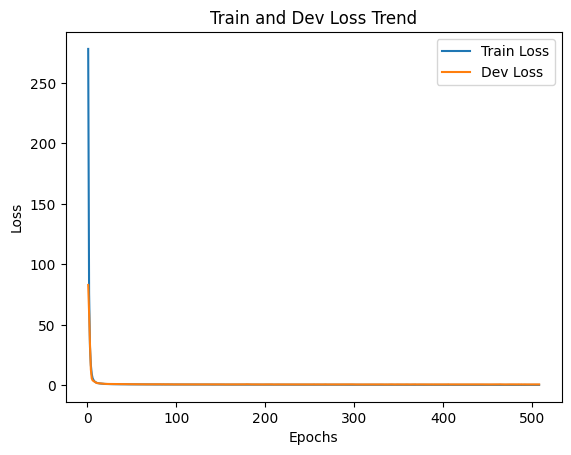

In [63]:
import matplotlib.pyplot as plt

# 取得 'train' 和 'dev' 的 x 軸資料，這裡假設 x 軸是 [1, 2, 3]
x_data = list(range(1, len(loss_record['train']) + 1))

# 'train' 和 'dev' 的 y 軸資料
train_losses = loss_record['train']
dev_losses = loss_record['dev']

# 繪製 'train' 和 'dev' 的趨勢直線圖
plt.plot(x_data, train_losses, label='Train Loss')
plt.plot(x_data, dev_losses, label='Dev Loss')

# 設定圖表標題和軸標籤
plt.title('Train and Dev Loss Trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 加入圖例
plt.legend()

# 顯示圖表
plt.show()

# Load the best model

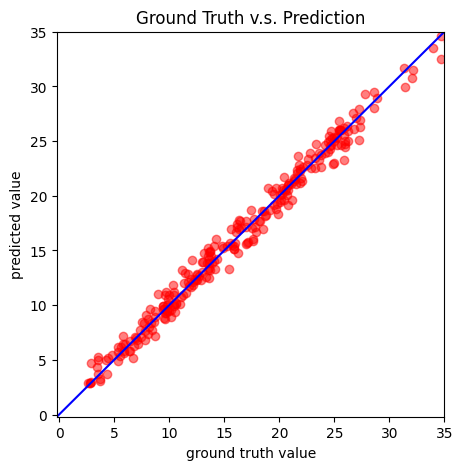

In [72]:
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

del model
model = MyModel(train_loader.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(val_loader, model, device)  # Show prediction on the validation set

# Testing

In [70]:
test_preds = test(model, test_loader)

In [73]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
save_pred(test_preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
